In [1]:
import skipthought
import tensorflow as tf
import numpy as np
from skipthought import utils
from skipthought.data_utils import Batch, TextData
import time
import math
from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
td = TextData('./data/chats1000.txt')

In [3]:
td.max_len

132

In [8]:
td.vocab

3746

In [6]:
td.dataset[:10]

['1: Добрый вечер! Подскажите, пожалуйста, где я могу выбрать категории повышенного кэшбека по карте?',
 '2: Вам нужно выбрать карту, затем нажать на кнопку под доступным остатком.',
 '1: да, думала, пора на следующий период выбирать. Банк меня оповестит, когда период, на который выбраны категории, закончится?',
 '2: Скорее всего да, т.к в прошлый раз поступала рассылка по эл. почте.',
 '2: Категории можно менять каждый квартал года.',
 '',
 '1: Закройте мне карту и вклад в долларах я его не открывал',
 '2: Как я вижу, заявку оставили через наши сервисы, например, через личный кабинет.',
 '1: Я тестировал открытие вклада но не карты',
 '1: Закройте все что связано с долларами']

In [4]:
input = td.encode_line(td.dataset[0], with_go=True)
target = td.encode_line(td.dataset[0], with_eos=True)

In [5]:
td.decode_line(target)

['1:',
 'Добрый',
 'вечер!',
 'Подскажите,',
 'пожалуйста,',
 'где',
 'я',
 'могу',
 'выбрать',
 'категории',
 'повышенного',
 'кэшбека',
 'по',
 'карте?',
 '<eos>']

In [2]:
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_integer('num_epochs', 500, "Number of epochs.")
tf.app.flags.DEFINE_integer('batch_size', 256, "The size of batch.")
tf.app.flags.DEFINE_integer('num_hidden', 128, 'Hidden size of GRU cell.')
tf.app.flags.DEFINE_integer('embedding_size', 64, 'The size of word embeddings.')
tf.app.flags.DEFINE_integer('max_vocab_size', 100, 'Size of vocabulary. Most frequent words are used.')
# tf.app.flags.DEFINE_integer('bottleneck_size', 128, 'Size of bottleneck softmax. It avoids matrices from num_hidden to vocab_size.')
tf.app.flags.DEFINE_float('learning_rate', 0.01, "Initial learning rate.")
tf.app.flags.DEFINE_float('decay_rate', 0.99, "Exponential decay rate.")
tf.app.flags.DEFINE_float('grad_clip', 5.0, "Value for gradient clipping.")

In [3]:
eos_token = 0
pad_token = 1
def gen_batch():
    encoder_inputs = Batch(np.random.randint(2, FLAGS.max_vocab_size, size=(FLAGS.batch_size, 10)), pad_value=pad_token)

    prev_inputs = np.hstack((eos_token*np.ones((FLAGS.batch_size,1), dtype=np.int32), encoder_inputs[:, :-1:2]))
    prev_inputs = np.hstack((prev_inputs, np.ones((FLAGS.batch_size, 4))))
    prev_inputs = Batch(prev_inputs, pad_value=pad_token)

    prev_target = Batch(np.hstack((encoder_inputs[:, ::2], eos_token*np.ones((FLAGS.batch_size,1), dtype=np.int32), pad_token*np.ones((FLAGS.batch_size, 4)))), pad_value=pad_token)
   
    next_inputs = np.hstack((eos_token*np.zeros((FLAGS.batch_size,1), dtype=np.int32), encoder_inputs[:, 1::2]))
    next_inputs = np.hstack((next_inputs, np.ones((FLAGS.batch_size, 4))))
    next_inputs = Batch(next_inputs, pad_value=1)
    
    next_target = Batch(np.hstack((encoder_inputs[:, 1::2], eos_token*np.ones((FLAGS.batch_size,1), dtype=np.int32), pad_token*np.ones((FLAGS.batch_size, 4)))), pad_value=pad_token)
    return encoder_inputs, prev_inputs, prev_target, next_inputs, next_target

In [4]:
batches = [gen_batch() for _ in range(1000)]

In [5]:
model = skipthought.SkipthoughtModel('lstm', FLAGS.num_hidden, FLAGS.embedding_size,
                                     FLAGS.max_vocab_size, FLAGS.learning_rate,
                                     FLAGS.decay_rate, len(batches)*FLAGS.batch_size, FLAGS.grad_clip, 10)

In [6]:
b = batches[0]

In [7]:
b[0][0]

array([63, 23, 27, 92,  8, 70, 57, 67, 13, 70])

In [8]:
b[1][0]

array([  0.,  63.,  27.,   8.,  57.,  13.,   1.,   1.,   1.,   1.])

In [9]:
b[2][0]

array([ 63.,  27.,   8.,  57.,  13.,   0.,   1.,   1.,   1.,   1.])

In [10]:
b[3][0]

array([  0.,  23.,  92.,  70.,  67.,  70.,   1.,   1.,   1.,   1.])

In [11]:
b[4][0]

array([ 23.,  92.,  70.,  67.,  70.,   0.,   1.,   1.,   1.,   1.])

In [17]:
def train(sess, verbose=1000):
    st = time.time()
    loss_history = []
    for e in range(FLAGS.num_epochs):
        for b in range(len(batches)):
            encoder_input, prev_input, prev_target, next_input, next_target = batches[b]
            feed_dict = model._fill_feed_dict_train(encoder_input, prev_input, prev_target,
                                                      next_input, next_target)

            start_time = time.time()
            batch_loss, _ = sess.run([model.loss, model.train_op], feed_dict=feed_dict)
            batch_perplexity = math.exp(float(batch_loss)) if batch_loss < 300 else float("inf")
            end_time = time.time()
            
            loss_history.append(batch_loss)
#             if b % verbose == 0:
#                         print(
#                             "{}/{} (epoch {}), train_loss = {:.3f}, perplexity = {:.3f}, time/batch = {:.3f}" \
#                             .format(e * len(batches) + b,
#                                     FLAGS.num_epochs * len(batches),
#                                     e, batch_loss, batch_perplexity, end_time - start_time))
                    
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(14, 10))

        plt.title("Training loss, epoch {}/{}".format(str(e+1), str(FLAGS.num_epochs)))
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % batch_loss)
        
    print(str(FLAGS.num_epochs), 'epochs trained for', time.time() - st)

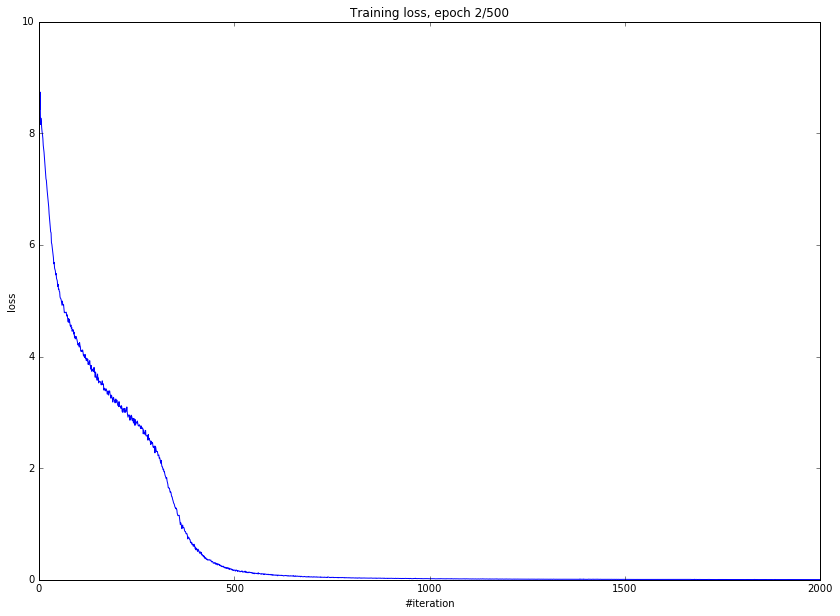

Current loss: 0.003788


KeyboardInterrupt: 

In [18]:
sess = tf.InteractiveSession()
init = tf.initialize_all_variables()
sess.run(init)
train(sess, verbose=1000)

In [28]:
for i, x in enumerate(tf.trainable_variables()):
    print(i, x.name)

0 embeddings/embedding_matrix:0
1 encoder/RNN/BasicLSTMCell/Linear/Matrix:0
2 encoder/RNN/BasicLSTMCell/Linear/Bias:0
3 prev_decoder/rnn_decoder/BasicLSTMCell/Linear/Matrix:0
4 prev_decoder/rnn_decoder/BasicLSTMCell/Linear/Bias:0
5 prev_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Matrix:0
6 prev_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Bias:0
7 next_decoder/rnn_decoder/BasicLSTMCell/Linear/Matrix:0
8 next_decoder/rnn_decoder/BasicLSTMCell/Linear/Bias:0
9 next_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Matrix:0
10 next_decoder/rnn_decoder/OutputProjectionWrapper/Linear/Bias:0


In [29]:
last_bias = tf.trainable_variables()[-1]

In [22]:
curr_b = Batch(np.array([[2, 3, 5, 8, 13, 21, 34, 55, 89, 44]]), pad_value=0)

prev_dec, next_dec, feed_dict = model.predict(curr_b, 0)
prev, next = sess.run([prev_dec, next_dec], feed_dict=feed_dict)
    

In [23]:
prev

[array([2]),
 array([5]),
 array([13]),
 array([34]),
 array([89]),
 array([0]),
 array([14]),
 array([76]),
 array([0]),
 array([47])]

In [24]:
next

[array([3]),
 array([8]),
 array([21]),
 array([55]),
 array([44]),
 array([0]),
 array([39]),
 array([77]),
 array([0]),
 array([89])]